## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [1]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allocator_type = 'BFC' #A "Best-fit with coalescing" algorithm, simplified from a version of dlmalloc.
config.gpu_options.per_process_gpu_memory_fraction = 0.8
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config)) 

C:\Users\cerbe\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\cerbe\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\cerbe\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\cerbe\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [1]:
import os
import keras
import itertools
# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""


Using TensorFlow backend.
C:\Users\cerbe\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\cerbe\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\cerbe\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\cerbe\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [17]:
from keras.layers import BatchNormalization
from keras.layers import Activation

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model



def build_mlp_tester(input_shape, output_units=10, num_neurons=[512, 256, 128], before = False):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   name="hidden_layer"+str(i+1))(input_layer)
            if before:
                x = BatchNormalization()(x)
                x = Activation("relu")(x)
            else:
                x = Activation("relu")(x)
                x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   name="hidden_layer"+str(i+1))(x)
            if before:
                x = BatchNormalization()(x)
                x = Activation("relu")(x)
            else:
                x = Activation("relu")(x)
                x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

## 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異, 先不將前後的批次正規畫放入做比較，單純看批次正規劃在不同batch下的影響

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = [2, 16, 32, 128, 256]
MOMENTUM = 0.95

In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""

for BATCH in BATCH_SIZE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Batch_size = %.6f" % (BATCH))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "batch_size-%s" % str(BATCH)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}




Experiment with Batch_size = 2.000000


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (Non

50000/50000 [==============================] - 129s 3ms/step - loss: 2.2685 - acc: 0.1435 - val_loss: 6.8391 - val_acc: 0.1712
Epoch 39/50
50000/50000 [==============================] - 129s 3ms/step - loss: 2.2572 - acc: 0.1481 - val_loss: 5.9021 - val_acc: 0.1812
Epoch 40/50
50000/50000 [==============================] - 129s 3ms/step - loss: 2.2645 - acc: 0.1409 - val_loss: 7.0881 - val_acc: 0.1770
Epoch 41/50
50000/50000 [==============================] - 127s 3ms/step - loss: 2.2722 - acc: 0.1407 - val_loss: 6.7123 - val_acc: 0.1755
Epoch 42/50
50000/50000 [==============================] - 128s 3ms/step - loss: 2.2719 - acc: 0.1418 - val_loss: 7.0368 - val_acc: 0.1605
Epoch 43/50
50000/50000 [==============================] - 128s 3ms/step - loss: 2.2645 - acc: 0.1471 - val_loss: 7.5590 - val_acc: 0.1531
Epoch 44/50
50000/50000 [==============================] - 128s 3ms/step - loss: 2.2612 - acc: 0.1469 - val_loss: 6.6357 - val_acc: 0.1893
Epoch 45/50
50000/50000 [==============

50000/50000 [==============================] - 17s 338us/step - loss: 1.1939 - acc: 0.5768 - val_loss: 1.4362 - val_acc: 0.5075
Epoch 37/50
50000/50000 [==============================] - 17s 339us/step - loss: 1.1824 - acc: 0.5801 - val_loss: 1.3646 - val_acc: 0.5280
Epoch 38/50
50000/50000 [==============================] - 17s 340us/step - loss: 1.1763 - acc: 0.5835 - val_loss: 1.3602 - val_acc: 0.5283
Epoch 39/50
50000/50000 [==============================] - 17s 339us/step - loss: 1.1666 - acc: 0.5861 - val_loss: 1.3682 - val_acc: 0.5239
Epoch 40/50
50000/50000 [==============================] - 17s 340us/step - loss: 1.1597 - acc: 0.5872 - val_loss: 1.3464 - val_acc: 0.5328
Epoch 41/50
50000/50000 [==============================] - 17s 341us/step - loss: 1.1572 - acc: 0.5908 - val_loss: 1.4627 - val_acc: 0.4948
Epoch 42/50
50000/50000 [==============================] - 17s 339us/step - loss: 1.1503 - acc: 0.5907 - val_loss: 1.5277 - val_acc: 0.4831
Epoch 43/50
50000/50000 [=======

50000/50000 [==============================] - 9s 171us/step - loss: 0.9181 - acc: 0.6708 - val_loss: 1.5707 - val_acc: 0.4940
Epoch 35/50
50000/50000 [==============================] - 9s 172us/step - loss: 0.9065 - acc: 0.6777 - val_loss: 1.6337 - val_acc: 0.4811
Epoch 36/50
50000/50000 [==============================] - 9s 171us/step - loss: 0.8910 - acc: 0.6820 - val_loss: 1.5068 - val_acc: 0.5158
Epoch 37/50
50000/50000 [==============================] - 9s 171us/step - loss: 0.8846 - acc: 0.6841 - val_loss: 1.5325 - val_acc: 0.5108
Epoch 38/50
50000/50000 [==============================] - 9s 170us/step - loss: 0.8768 - acc: 0.6877 - val_loss: 1.5287 - val_acc: 0.5057
Epoch 39/50
50000/50000 [==============================] - 9s 170us/step - loss: 0.8715 - acc: 0.6890 - val_loss: 1.4998 - val_acc: 0.5193
Epoch 40/50
50000/50000 [==============================] - 9s 171us/step - loss: 0.8528 - acc: 0.6960 - val_loss: 1.5736 - val_acc: 0.5126
Epoch 41/50
50000/50000 [==============

50000/50000 [==============================] - 3s 68us/step - loss: 0.4784 - acc: 0.8343 - val_loss: 2.0430 - val_acc: 0.4725
Epoch 33/50
50000/50000 [==============================] - 3s 68us/step - loss: 0.4608 - acc: 0.8414 - val_loss: 2.0612 - val_acc: 0.4766
Epoch 34/50
50000/50000 [==============================] - 3s 68us/step - loss: 0.4522 - acc: 0.8424 - val_loss: 2.0248 - val_acc: 0.4749
Epoch 35/50
50000/50000 [==============================] - 3s 68us/step - loss: 0.4278 - acc: 0.8520 - val_loss: 2.2195 - val_acc: 0.4548
Epoch 36/50
50000/50000 [==============================] - 3s 68us/step - loss: 0.4193 - acc: 0.8551 - val_loss: 2.3369 - val_acc: 0.4437
Epoch 37/50
50000/50000 [==============================] - 3s 68us/step - loss: 0.4055 - acc: 0.8594 - val_loss: 2.2898 - val_acc: 0.4614
Epoch 38/50
50000/50000 [==============================] - 3s 68us/step - loss: 0.3920 - acc: 0.8655 - val_loss: 2.0571 - val_acc: 0.4832
Epoch 39/50
50000/50000 [=====================

Epoch 31/50
50000/50000 [==============================] - 2s 48us/step - loss: 0.4580 - acc: 0.8508 - val_loss: 1.8787 - val_acc: 0.4663
Epoch 32/50
50000/50000 [==============================] - 2s 48us/step - loss: 0.4280 - acc: 0.8628 - val_loss: 1.9122 - val_acc: 0.4792
Epoch 33/50
50000/50000 [==============================] - 2s 48us/step - loss: 0.4143 - acc: 0.8680 - val_loss: 1.9654 - val_acc: 0.4771
Epoch 34/50
50000/50000 [==============================] - 2s 48us/step - loss: 0.3922 - acc: 0.8742 - val_loss: 1.9535 - val_acc: 0.4777
Epoch 35/50
50000/50000 [==============================] - 2s 49us/step - loss: 0.3744 - acc: 0.8820 - val_loss: 2.0396 - val_acc: 0.4676
Epoch 36/50
50000/50000 [==============================] - 2s 49us/step - loss: 0.3529 - acc: 0.8899 - val_loss: 2.1327 - val_acc: 0.4608
Epoch 37/50
50000/50000 [==============================] - 2s 48us/step - loss: 0.3373 - acc: 0.8940 - val_loss: 2.1865 - val_acc: 0.4668
Epoch 38/50
50000/50000 [=========

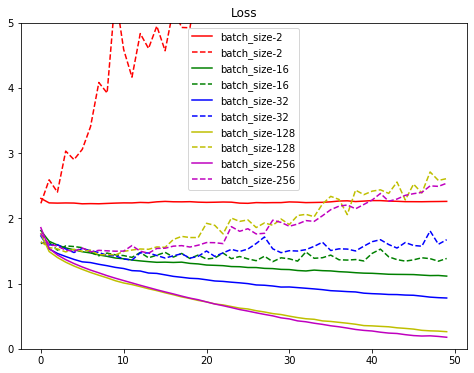

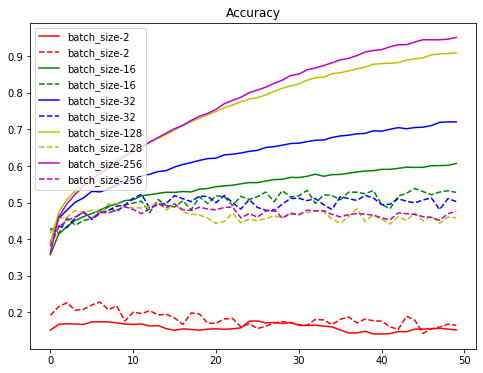

In [8]:
"""Code Here
將結果繪出
"""
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

Batch-size太小的時候狀況都會很差，但是可以看到在中間值大概是16,32這兩種設置時因為有在每層搭載正規化讓其驗證結果與128,256接近

## 請嘗試將 BN 放在 Activation 之前，並比較訓練結果；請於 BN 放在 Input Layer 後，並比較結果

In [20]:
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95
ACTIVATOR = [True, False]

In [21]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""

for Activator in ACTIVATOR:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Batch_size = %.6f" % (BATCH))
    print("before activation = ", Activator)
    model = build_mlp_tester(input_shape=x_train.shape[1:], before = Activator)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "Act-%s" % str(Activator)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Batch_size = 256.000000
before activation =  True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
activation

50000/50000 [==============================] - 2s 32us/step - loss: 0.6058 - acc: 0.8267 - val_loss: 1.5261 - val_acc: 0.4987
Epoch 47/50
50000/50000 [==============================] - 2s 31us/step - loss: 0.5876 - acc: 0.8354 - val_loss: 1.5569 - val_acc: 0.4949
Epoch 48/50
50000/50000 [==============================] - 2s 31us/step - loss: 0.5709 - acc: 0.8411 - val_loss: 1.5529 - val_acc: 0.4995
Epoch 49/50
50000/50000 [==============================] - 2s 32us/step - loss: 0.5522 - acc: 0.8486 - val_loss: 1.5338 - val_acc: 0.5086
Epoch 50/50
50000/50000 [==============================] - 2s 32us/step - loss: 0.5346 - acc: 0.8565 - val_loss: 1.5575 - val_acc: 0.5032
Experiment with Batch_size = 256.000000
before activation =  False
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________

50000/50000 [==============================] - 2s 32us/step - loss: 0.6548 - acc: 0.7983 - val_loss: 1.5632 - val_acc: 0.4990
Epoch 42/50
50000/50000 [==============================] - 2s 32us/step - loss: 0.6408 - acc: 0.8015 - val_loss: 1.5664 - val_acc: 0.4924
Epoch 43/50
50000/50000 [==============================] - 2s 32us/step - loss: 0.6194 - acc: 0.8117 - val_loss: 1.5756 - val_acc: 0.4923
Epoch 44/50
50000/50000 [==============================] - 2s 32us/step - loss: 0.6024 - acc: 0.8189 - val_loss: 1.5949 - val_acc: 0.4956
Epoch 45/50
50000/50000 [==============================] - 2s 32us/step - loss: 0.5854 - acc: 0.8238 - val_loss: 1.6112 - val_acc: 0.4935
Epoch 46/50
50000/50000 [==============================] - 2s 32us/step - loss: 0.5673 - acc: 0.8323 - val_loss: 1.6130 - val_acc: 0.4932
Epoch 47/50
50000/50000 [==============================] - 2s 32us/step - loss: 0.5514 - acc: 0.8372 - val_loss: 1.6458 - val_acc: 0.4941
Epoch 48/50
50000/50000 [=====================

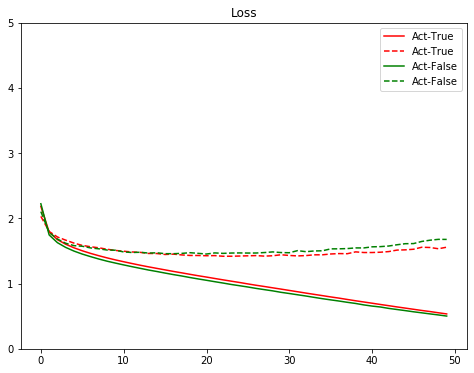

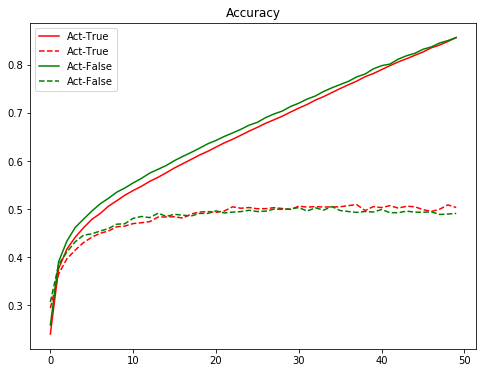

In [22]:
"""Code Here
將結果繪出
"""
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

在進入函數前導入正規化效果會較之後稍佳